In [79]:
import nltk
from nltk.corpus import gutenberg
import re
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
emma=gutenberg.paras('austen-emma.txt')

emma_paras=[]
for paragraph in emma:
    para=paragraph[0]
    #removing the double-dash from all words
    para=[re.sub(r'--','',word) for word in para]
    #Forming each paragraph into a string and adding it to the list of strings.
    emma_paras.append(' '.join(para))

In [125]:
from sklearn.feature_extraction.text import TfidfVectorizer

X_train, X_test = train_test_split(emma_paras, test_size=0.4, random_state=0)

vectorizer = TfidfVectorizer(max_df=0.5, # drop words that occur in more than half the paragraphs
                             min_df=5, # only use words that appear at least twice
#                              stop_words='english', 
                             lowercase=True, #convert everything to lower case (since Alice in Wonderland has the HABIT of CAPITALIZING WORDS for EMPHASIS)
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )


#Applying the vectorizer
emma_paras_tfidf = vectorizer.fit_transform(emma_paras)
print("Number of features: %d" % emma_paras_tfidf.get_shape()[1])

#splitting into training and test sets
X_train_tfidf, X_test_tfidf= train_test_split(emma_paras_tfidf, test_size=0.4, random_state=0)


#Reshapes the vectorizer output into something people can read
X_train_tfidf_csr = X_train_tfidf.tocsr()

#number of paragraphs
n = X_train_tfidf_csr.shape[0]
#A list of dictionaries, one per paragraph
tfidf_bypara = [{} for _ in range(0,n)]
#List of features
terms = vectorizer.get_feature_names()
#for each paragraph, lists the feature words and their tf-idf scores
for i, j in zip(*X_train_tfidf_csr.nonzero()):
    tfidf_bypara[i][terms[j]] = X_train_tfidf_csr[i, j]

#Keep in mind that the log base 2 of 1 is 0, so a tf-idf score of 0 indicates that the word was present once in that sentence.
print('Original sentence:', X_train[7])
print('Tf_idf vector:', tfidf_bypara[7])

Number of features: 1001
Original sentence: " Very well ; and if he had intended to give her one , he would have told her so ."
Tf_idf vector: {'intended': 0.40826552712668357, 'would': 0.23235611653040575, 'told': 0.3587926466493395, 'if': 0.23235611653040575, 'so': 0.20231132377521, 'give': 0.2964641884812501, 'have': 0.1869502800698184, 'he': 0.3435520885276093, 'well': 0.23364961165979958, 'her': 0.3218869987246837, 'very': 0.17671196153741497, 'one': 0.24948175861896693, 'had': 0.1820826621106759, 'to': 0.11826054931223771, 'and': 0.12648215363064}


In [126]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

#Our SVD data reducer.  We are going to reduce the feature space from 1379 to 130.
svd= TruncatedSVD(130)
lsa = make_pipeline(svd, Normalizer(copy=False))
# Run SVD on the training data, then project the training data.
X_train_lsa = lsa.fit_transform(X_train_tfidf)
X_test_lsa = lsa.transform(X_test_tfidf)

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:",total_variance*100)
print('---------------------------------------------')

#Looking at what sorts of paragraphs our solution considers similar, for the first five identified topics
train_paras_by_component=pd.DataFrame(X_train_lsa,index=X_train)
print('training set')
print('------------')
for i in range(5):
    print('Component {}:'.format(i))
    print(train_paras_by_component.loc[:,i].sort_values(ascending=False)[0:10])

print('---------------------------------------------')
test_paras_by_component=pd.DataFrame(X_test_lsa,index=X_test)
print('test set')
print('------------')
for i in range(5):
    print('Component {}:'.format(i))
    print(test_paras_by_component.loc[:,i].sort_values(ascending=False)[0:10])

Percent variance captured by all components: 59.06325148605538
---------------------------------------------
training set
------------
Component 0:
Mrs . Weston was acting no part , feigning no feelings in all that she said to him in favour of the event . She had been extremely surprized , never more so , than when Emma first opened the affair to her ; but she saw in it only increase of happiness to all , and had no scruple in urging him to the utmost . She had such a regard for Mr . Knightley , as to think he deserved even her dearest Emma ; and it was in every respect so proper , suitable , and unexceptionable a connexion , and in one respect , one point of the highest importance , so peculiarly eligible , so singularly fortunate , that now it seemed as if Emma could not safely have attached herself to any other creature , and that she had herself been the stupidest of beings in not having thought of it , and wished it long ago . How very few of those men in a rank of life to address

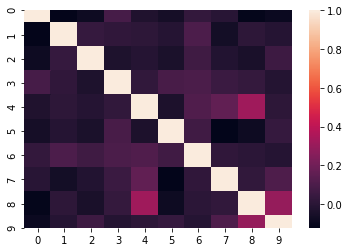

Key:
0 That is _court_ .
1 " Yes , sir , I did indeed ; and I am very much obliged by your kind solicitude about me ."
2 " How much his business engrosses him already is very plain from the circumstance of his forgetting to inquire for the book you recommended .
3 To restrain him as much as might be , by her own manners , she was immediately preparing to speak with exquisite calmness and gravity of the weather and the night ; but scarcely had she begun , scarcely had they passed the sweep - gate and joined the other carriage , than she found her subject cut up  her hand seized  her attention demanded , and Mr . Elton actually making violent love to her : availing himself of the precious opportunity , declaring sentiments which must be already well known , hoping  fearing  adoring  ready to die if she refused him ; but flattering himself that his ardent attachment and unequalled love and unexampled passion could not fail of having some effect , and in short , very much resolved on being

In [124]:
# Compute document similarity using LSA components
similarity = np.asarray(np.asmatrix(X_train_lsa) * np.asmatrix(X_train_lsa).T)
#Only taking the first 10 sentences
sim_matrix=pd.DataFrame(similarity,index=X_train).iloc[0:10,0:10]
#Making a plot
ax = sns.heatmap(sim_matrix,yticklabels=range(10))
plt.show()

#Generating a key for the plot.
print('Key:')
for i in range(10):
    print(i,sim_matrix.index[i])